### 統計學習與深度學習 (Fall, 2024)
### Homework 1

請將IPYNB檔與IPYNB Export之HTML檔上傳至COOL作業區。作業自己做。嚴禁抄襲。不接受紙本繳交，不接受遲交。請以英文或中文作答。
如無其他規定，所有重要結果應顯示至小數點第四位(四捨五入)。本次作業盡可能使用scikit-learn的函數與numpy進行實作。禁止使用Auto-SKlearn或其他AutoML工具。


### 第一題 [Ridge Regression Baseline]

(30%) 以Ridge Regression進行房價預測。Regularizaiton coefficient (alphas)應考慮介於0.01至100之間的數值，且至少應考慮十種可能的數值。

訓練資料檔案為'housing_5cities_train.csv', 測試資料檔案為 'housing_5cities_testa.csv'。預測標的為'單價'。你的模型應包含以下特徵:
* 建物面積
* 總樓層數
* 屋齡
* 縣市
* 鄉鎮市區
* 主要用途
* 主要建材
* 建物型態

類別型特徵應進行適當的轉換。

(1) 畫出高雄市資料點的分布，橫坐標為x軸，縱坐標為y軸。依照單價將資料點上色。說明你對資料點個觀察。

(2) 列出最終選用的Regularization Coefficient，以下模型參數，並報告模型在測試資料的預測能力 (包含R2、RMSE、MAE、MAPE)。
* Constant term coefficient
* 建物面積
* 總樓層數
* 屋齡
* 台中市
* 台北市
* 新北市
* 桃園市
* 高雄市

### 第二題 [Gaussian Basis Function]

(30%) Gaussian Basis Function (GBF) 常用來擴展特徵。在房價預測中，我們可以挑選某些位置作為GBF的均數，並設定合理的變異數，即可利用GBF識別某筆資料是否為在選定的位置附近。

我們在課程中定義過一維情境下計算GBF特徵值的公式為:

$exp(- \frac{(x_a - \mu_j)^2}{2 s_j^2}), $

其中 $x_a$ 為資料點，而 $mu_j$  是選定的錨點 (Anchor)，標準差$s_j$ 是用來控管要訂多寬的區域。

房價資料的位置資訊為二維空間，因此如果資料點的位置是 $(x_a, y_a)$, 錨點是 $(\mu_{xj}, \mu_{yj})$、標準差是 $(s_{xj}, s_{yj})$，那GBF特徵值為:

$exp(- \frac{(x_a - \mu_{xj})^2}{2 s_{xj}^2} - \frac{(y_a - \mu_{yj})^2}{2 s_{yj}^2} )$

這題我們只選擇一個錨點，定為所有高雄市的訓練資料的中心點。X軸的標準差為高雄市的資料X座標的標準差，並利用相同的方式定Y軸的標準差。利用上面的公式計算GBF資料數值。

(1) 列出錨點座標與標準差

(2) 為所有訓練資料計算GBF特徵值，並且依照縣市列出這個特徵值的count, mean, std, min, 25%, 50%, 75%, max。


### 第三題 [Applying GBF in Prediction Models]

(40%) 依照以下方式產生錨點，並使用GBF生成新的特徵，與第一題所有的特徵合併後，建構新的Ridge Regression預測模型，並計算其在測試資料上的預測能力(包含R2、RMSE、MAE、MAPE)。

對每個城市C，找出能包含所有資料點的長方形，並將橫軸與縱軸個切$K$等分，形成$K^2$個格子。如果一個格子內有超過20個資料點，計算這個格子內的所有資料點的均數與標準差，做為一個錨點。格子內如果少於20個資料點則直接略過這個格子。

(1) 列出各縣市的錨點。

(2) 設K=3, 列出測試資料的R2、RMSE、MAE、MAPE，並與第一題比較。


### 第一題 [Ridge Regression Baseline]

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
from sklearn import metrics
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option('display.max_column', 500)
pd.set_option('display.max_rows', 5000)
random.seed(1001)

In [2]:
# training data
dftrain = pd.read_csv('./housing_5cities_train.csv')
# test data
dftesta = pd.read_csv('./housing_5cities_testa.csv')
print(f"Training df shape = {dftrain.shape}; test df shape = {dftesta.shape}")

Training df shape = (8140, 21); test df shape = (1031, 21)


In [3]:
dftrain_ks = dftrain[dftrain.縣市 == "高雄市"]

<Axes: xlabel='橫坐標', ylabel='縱坐標'>

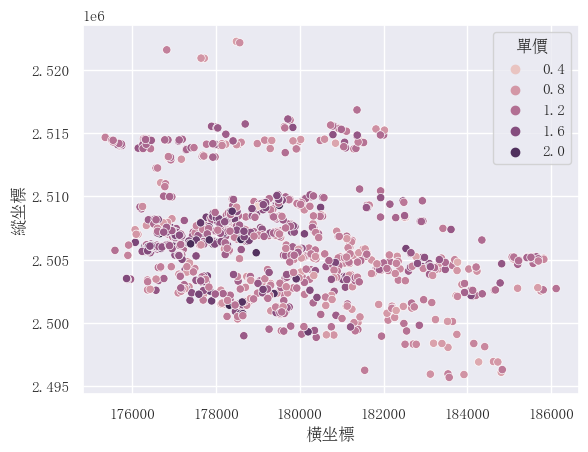

In [4]:
sns.set(font="SimSun")
sns.scatterplot(dftrain_ks, x="橫坐標", y="縱坐標", hue = "單價")

#### 依照高雄單價的分布圖可以發現，於座標左上及右下的單價平均分布較稀疏，單價相對也較小。而大部分資料點集中在橫座標 176,000-180,000，以及縱坐標 2.500-2.510 之間，這部分同時也是最多高單價房屋的區域。整體可以看到資料點有從左上往右下的分布，並集中在中央。

In [5]:
# Utility functions
def gen_features(dftrain, dftest, numfeatures, catfeatures, enc):
    # Generate additional categorical features according to catfeatures
    # Arrange numpy array such that numerical features go first, followed by categorical features
    # return the feature arrary for training and test data

    X_train = dftrain[numfeatures].to_numpy()    
    enc.fit(dftrain[catfeatures])
    X_train_cat = enc.transform(dftrain[catfeatures]).toarray()
    X_train2 = np.hstack((X_train, X_train_cat))

    X_test = dftesta[numfeatures].to_numpy()
    X_test_cat = enc.transform(dftesta[catfeatures]).toarray()
    X_test2 = np.hstack((X_test, X_test_cat))

    return X_train2, X_test2

In [6]:
numfeatures = ['建物面積', '總樓層數', '屋齡']
catfeatures = ['縣市', '鄉鎮市區', '主要用途', '主要建材', '建物型態']
label = '單價'

y_train = dftrain[label].to_numpy()
y_test = dftesta[label].to_numpy()

enc = OneHotEncoder(handle_unknown='ignore')
X_train, X_test = gen_features(dftrain, dftesta, numfeatures, catfeatures, enc)
# print(f"Training df shape = {X_train.shape}; test df shape = {X_test.shape}")

catnames = []
for a in enc.categories_:
    catnames.extend(list(a))

# ['Const.'] +
# constant terms not included here
featnames =  numfeatures + catnames
# print(f"First few features: {featnames[0:10]}...")

In [7]:
ridgecv = linear_model.RidgeCV(alphas=np.linspace(0.01, 100, num=10))
ridgecv.fit(X_train, y_train)


print(f"Regularization Coefficient: {ridgecv.alpha_:.4f}")
print(f"Constant term coefficientt: {ridgecv.intercept_:.4f}")

for aname, acoef in zip(featnames, ridgecv.coef_[0:8]):
    print(f"{aname}\t{acoef:.4f}")

Regularization Coefficient: 0.0100
Constant term coefficientt: 2.1429
建物面積	0.0023
總樓層數	0.0048
屋齡	-0.0214
台中市	-0.4540
台北市	1.6495
新北市	0.0216
桃園市	-0.6218
高雄市	-0.5954


In [8]:
yhead_test = ridgecv.predict(X_test)

r2_test = metrics.r2_score(y_test, yhead_test)
mse_test = metrics.mean_squared_error(y_test, yhead_test)
rmse_test = np.sqrt(mse_test)
mae_test = metrics.mean_absolute_error(y_test, yhead_test)
mape_test = metrics.mean_absolute_percentage_error(y_test, yhead_test)

print("Test performance:")
print(f"R2 = {r2_test:.4f}")
print(f"RMSE = {rmse_test:.4f}")
print(f"MAE = {mae_test:.4f}")
print(f"MAPE = {mape_test:.4f}")

Test performance:
R2 = 0.7681
RMSE = 0.5044
MAE = 0.2820
MAPE = 0.1332


### 第二題 [Gaussian Basis Function]

In [9]:
# loop over all grids
# for each grid
#    identify grids in the points
#    compute the center of these points
#    computer the std along x and y axis
#    skip if too few points
#    record uj and sj, and data point count

mu_x_all = []
mu_y_all = []
std_x_all = []
std_y_all = []
count_all = []

ngrid = 1 # divide into ngrid by ngrid

cities = ['高雄市']
for acity in cities:
    dftrain_ks = dftrain[dftrain.縣市 == acity]
    print(acity, dftrain_ks.shape)
    coord_x = dftrain_ks.橫坐標.values
    coord_y = dftrain_ks.縱坐標.values
    
    xmin = min(coord_x)
    xmax = max(coord_x) + 0.1 # a convenient slack to fix boundary issue
    ymin = min(coord_y)
    ymax = max(coord_y) + 0.1 # a convenient slack to fix boundary issue
    
    xgrids = np.linspace(xmin, xmax, ngrid+1)
    ygrids = np.linspace(ymin, ymax, ngrid+1)
    
    
    for i in range(ngrid):
        for j in range(ngrid):
            x1 = xgrids[i]
            x2 = xgrids[i+1]
            y1 = ygrids[j]
            y2 = ygrids[j+1]
            tmpindx = (x1 <= coord_x) * (coord_x < x2)
            tmpindy = (y1 <= coord_y) * (coord_y < y2)
            tmpind = tmpindx * tmpindy
            npoints = np.sum(tmpind)
            if npoints < 20:
                print(f" - Only {npoints} points in grid {i}, {j}, skip")
                continue
            mu_x = np.mean(coord_x[tmpind])
            mu_y = np.mean(coord_y[tmpind])
            std_x = np.std(coord_x[tmpind])
            std_y = np.std(coord_y[tmpind])
#            print(f"grid {i}, {j} N={npoints}")
            print(f"Mean=({mu_x:.4f}, {mu_y:.4f})\tStd=({std_x:.4f}, {std_y:.4f})")
            
            mu_x_all.append(mu_x)
            mu_y_all.append(mu_y)
            std_x_all.append(std_x)
            std_y_all.append(std_y)
            count_all.append(npoints)

高雄市 (1067, 21)
Mean=(179372.9859, 2506459.4171)	Std=(2313.7378, 4031.4941)


In [10]:
# len(mu_x_all)

In [11]:
# add 1 new features
def gaussin_basis(coord_x, coord_y, mu_x_all, mu_y_all, std_x_all, std_y_all):
    ngf = len(mu_x_all)
    gf_all = np.zeros((coord_x.shape[0], ngf))
    
    for ii in range(ngf):
         mu_x = mu_x_all[ii]
         mu_y = mu_y_all[ii]
         std_x = std_x_all[ii]
         std_y = std_y_all[ii]
        
         # doing this in a vectorized way
         tmpgf = np.exp(-(coord_x - mu_x) ** 2 / (2 * std_x ** 2) - (coord_y - mu_y) ** 2 / (2 * std_y ** 2))
         gf_all[:,ii] = tmpgf
    
    return gf_all

coord_x = dftrain.橫坐標.values
coord_y = dftrain.縱坐標.values
gf_all_train = gaussin_basis(coord_x, coord_y, mu_x_all, mu_y_all, std_x_all, std_y_all)

In [12]:
# gf_all_train

In [13]:
# 設置 pandas 顯示選項
pd.set_option('display.float_format', '{:.4f}'.format)

# 將 GBF 特徵值和縣市合併成新的 DataFrame
df_gbf = pd.DataFrame(gf_all_train, columns=[f'GBF_{i+1}' for i in range(gf_all_train.shape[1])])
df_gbf['縣市'] = dftrain['縣市'].values
df_gbf

,GBF_1,縣市
0,0.0000,台北市
1,0.0570,高雄市
2,0.0000,新北市
3,0.0000,台北市
4,0.0000,新北市
...,...,...
8135,0.0000,台北市
8136,0.0000,新北市
8137,0.0000,桃園市
8138,0.0000,新北市


In [14]:
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = '{:02.0f}%'.format(n * 100)  # 修改名稱為 25%
    return percentile_

# 依縣市分組並計算統計資訊
gbf_stats = df_gbf.groupby('縣市').agg(['count', 'mean', 'std', 'min', percentile(0.25), percentile(0.50), percentile(0.75), 'max'])

# 顯示統計資訊
print(gbf_stats)

    GBF_1                                                 
    count   mean    std    min    25%    50%    75%    max
縣市                                                        
台中市   810 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
台北市  1906 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
新北市  3432 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
桃園市   925 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
高雄市  1067 0.5189 0.2928 0.0004 0.2582 0.5589 0.7628 0.9944


### 第三題 [Applying GBF in Prediction Models]

In [15]:
# loop over all grids
# for each grid
#    identify grids in the points
#    compute the center of these points
#    computer the std along x and y axis
#    skip if too few points
#    record uj and sj, and data point count

mu_x_all = []
mu_y_all = []
std_x_all = []
std_y_all = []
count_all = []

ngrid = 3 # divide into ngrid by ngrid

cities = ['台中市',  '台北市', '新北市', '桃園市', '高雄市']
for acity in cities:
    dftrain_ks = dftrain[dftrain.縣市 == acity]
    print(acity, dftrain_ks.shape)
    coord_x = dftrain_ks.橫坐標.values
    coord_y = dftrain_ks.縱坐標.values
    
    xmin = min(coord_x)
    xmax = max(coord_x) + 0.1 # a convenient slack to fix boundary issue
    ymin = min(coord_y)
    ymax = max(coord_y) + 0.1 # a convenient slack to fix boundary issue
    
    xgrids = np.linspace(xmin, xmax, ngrid+1)
    ygrids = np.linspace(ymin, ymax, ngrid+1)
    
    
    for i in range(ngrid):
        for j in range(ngrid):
            x1 = xgrids[i]
            x2 = xgrids[i+1]
            y1 = ygrids[j]
            y2 = ygrids[j+1]
            tmpindx = (x1 <= coord_x) * (coord_x < x2)
            tmpindy = (y1 <= coord_y) * (coord_y < y2)
            tmpind = tmpindx * tmpindy
            npoints = np.sum(tmpind)
            if npoints < 20:
                print(f" - Only {npoints} points in grid {i}, {j}, skip")
                continue
            mu_x = np.mean(coord_x[tmpind])
            mu_y = np.mean(coord_y[tmpind])
            std_x = np.std(coord_x[tmpind])
            std_y = np.std(coord_y[tmpind])
            print(f"grid {i}, {j} N={npoints}; \tMean=({mu_x:.4f}, {mu_y:.4f})\tStd=({std_x:.4f}, {std_y:.4f})")
            
            mu_x_all.append(mu_x)
            mu_y_all.append(mu_y)
            std_x_all.append(std_x)
            std_y_all.append(std_y)
            count_all.append(npoints)

台中市 (810, 21)
 - Only 15 points in grid 0, 0, skip
 - Only 8 points in grid 0, 1, skip
 - Only 0 points in grid 0, 2, skip
grid 1, 0 N=97; 	Mean=(214825.1031, 2668597.5876)	Std=(1155.6803, 1060.0441)
grid 1, 1 N=370; 	Mean=(213825.3162, 2672811.4595)	Std=(1734.3512, 1861.5749)
 - Only 4 points in grid 1, 2, skip
grid 2, 0 N=55; 	Mean=(218624.5636, 2667625.3091)	Std=(1198.7754, 1470.7164)
grid 2, 1 N=238; 	Mean=(219354.1891, 2673598.5630)	Std=(1592.1233, 1615.3629)
grid 2, 2 N=23; 	Mean=(220461.6957, 2680783.0435)	Std=(1165.7283, 2578.4133)
台北市 (1906, 21)
grid 0, 0 N=90; 	Mean=(300711.6667, 2768906.2667)	Std=(714.5537, 531.0706)
grid 0, 1 N=146; 	Mean=(301296.2397, 2772116.7192)	Std=(549.8669, 1735.3693)
grid 0, 2 N=122; 	Mean=(300588.1475, 2779867.8934)	Std=(1331.3471, 1608.3421)
grid 1, 0 N=430; 	Mean=(304968.3372, 2768095.4512)	Std=(1361.0391, 1561.2120)
grid 1, 1 N=565; 	Mean=(304675.4496, 2772124.5858)	Std=(1445.8699, 1476.4261)
grid 1, 2 N=144; 	Mean=(303477.9583, 2778399.4375)	St

In [16]:
len(mu_x_all)

32

In [17]:
# add 32 new features
def gaussin_basis(coord_x, coord_y, mu_x_all, mu_y_all, std_x_all, std_y_all):
    ngf = len(mu_x_all)
    gf_all = np.zeros((coord_x.shape[0], ngf))
    
    for ii in range(ngf):
        mu_x = mu_x_all[ii]
        mu_y = mu_y_all[ii]
        std_x = std_x_all[ii]
        std_y = std_y_all[ii]
        
        # doing this in a vectorized way
        tmpgf = np.exp(-(coord_x - mu_x) ** 2 / (2 * std_x ** 2) - (coord_y - mu_y) ** 2 / (2 * std_y ** 2))
        gf_all[:,ii] = tmpgf
    
    return gf_all

coord_x = dftrain.橫坐標.values
coord_y = dftrain.縱坐標.values
gf_all_train = gaussin_basis(coord_x, coord_y, mu_x_all, mu_y_all, std_x_all, std_y_all)
gf_all_test = gaussin_basis(dftesta.橫坐標.values, dftesta.縱坐標.values, mu_x_all, mu_y_all, std_x_all, std_y_all)
y_train2 = y_train

# add gaussian features
X_train2 = np.hstack((X_train, gf_all_train))
X_test2 = np.hstack((X_test, gf_all_test))
y_test2 = y_test

In [18]:
ridgecv2 = linear_model.RidgeCV(alphas=np.linspace(0.01, 100, num=10))
ridgecv2.fit(X_train2, y_train2)


print(f"Regularization Coefficient: {ridgecv2.alpha_:.4f}")
print(f"Constant term coefficient: {ridgecv2.intercept_:.4f}")
for aname, acoef in zip(featnames, ridgecv2.coef_[0:8]):
    print(f"{aname}\t{acoef:.4f}")

Regularization Coefficient: 0.0100
Constant term coefficient: 2.1259
建物面積	-0.0038
總樓層數	0.0042
屋齡	-0.0223
台中市	-0.4626
台北市	1.5679
新北市	0.0884
桃園市	-0.5884
高雄市	-0.6052


In [19]:
yhead_test2 = ridgecv2.predict(X_test2)

r2_test2 = metrics.r2_score(y_test2, yhead_test2)
mse_test2 = metrics.mean_squared_error(y_test2, yhead_test2)
rmse_test2 = np.sqrt(mse_test2)
mae_test2 = metrics.mean_absolute_error(y_test2, yhead_test2)
mape_test2 = metrics.mean_absolute_percentage_error(y_test2, yhead_test2)

print("Test performance:")
print(f"R2 = {r2_test2:.4f}")
print(f"RMSE = {rmse_test2:.4f}")
print(f"MAE = {mae_test2:.4f}")
print(f"MAPE = {mape_test2:.4f}")

Test performance:
R2 = 0.7800
RMSE = 0.4913
MAE = 0.2719
MAPE = 0.1286


##### 與第一題相較，加入 GBF 後的模型 Test performance 在各個指標上都比原始模型有輕微的改善。R² 增加表示模型的解釋能力更好，而 RMSE、MAE 和 MAPE 的減少則顯示模型預測的誤差更小，顯示在利用 GBF 針對地理位置的特徵進行 feature engineering 後，房價預測的模型預測表現有明顯的改善。